# Try [`scuff-em`](http://homerreid.github.io/scuff-em-documentation/) in your browser!
This uses the services of [mybinder.org](http://mybinder.org) to run a Docker container with `scuff-em` precompiled in the browser, with the interface provided by [Jupyter](http://jupyter.org) notebooks. The notebook is written in python 3 using the [IPython kernel](http://ipython.readthedocs.org/en/latest/), which provides convenient "magic" functions to call shell commands etc, but also allows for nice plotting in the notebook.

## some setup code for plotting

In [1]:
from cycler import cycler
%pylab inline
%config InlineBackend.figure_formats = ['retina']
style.use(['seaborn-deep','seaborn-notebook'])
rc('axes',prop_cycle=cycler('color',['#4C72B0','#C44E52','#55A868','#8172B2','#CCB974','#64B5CD']))

Populating the interactive namespace from numpy and matplotlib


# Try some scuff example
We have included all the examples of `scuff-em` here. Check what is available:

In [2]:
%ls

Args                       SiCSphere.scuffgeo
GoldData.png               Sphere.cache
L0P5RCoarse.png            Sphere.geo
Mie.math                   Sphere.msh
MieScattering.md           SphereMesh.png
OmegaValues.dat            SphereSurfaceCurrents.png
SiC.mie                    index.ipynb
SiCData.png                scuff-scatter.log
SiCSphere.PFT


# Mie scattering example
We now follow the [Mie Scattering](http://homerreid.github.io/scuff-em-documentation/examples/MieScattering/MieScattering/) example from the scuff-em documentation.

In [3]:
%cd MieScattering
%ls

[Errno 2] No such file or directory: 'MieScattering'
/Users/feist/Documents/work/progs/sers/scuff/test_example/MieScattering
Args                       SiCSphere.scuffgeo
GoldData.png               Sphere.cache
L0P5RCoarse.png            Sphere.geo
Mie.math                   Sphere.msh
MieScattering.md           SphereMesh.png
OmegaValues.dat            SphereSurfaceCurrents.png
SiC.mie                    index.ipynb
SiCData.png                scuff-scatter.log
SiCSphere.PFT


In [4]:
%%bash
gmsh -2 -clscale 1.0 Sphere.geo

Info    : Running 'gmsh -2 -clscale 1.0 Sphere.geo' [Gmsh 2.8.4, 1 node, max. 1 thread]
Info    : Started on Sat Feb 27 20:59:02 2016
Info    : Reading 'Sphere.geo'...
Info    : Done reading 'Sphere.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Meshing curve 2 (Circle)
Info    : Meshing curve 3 (Circle)
Info    : Meshing curve 4 (Circle)
Info    : Meshing curve 5 (Circle)
Info    : Meshing curve 6 (Circle)
Info    : Meshing curve 7 (Circle)
Info    : Meshing curve 8 (Circle)
Info    : Meshing curve 9 (Circle)
Info    : Meshing curve 10 (Circle)
Info    : Meshing curve 11 (Circle)
Info    : Meshing curve 12 (Circle)
Info    : Done meshing 1D (0.001438 s)
Info    : Meshing 2D...
Info    : Meshing surface 14 (Ruled surface, MeshAdapt)
Info    : Meshing surface 16 (Ruled surface, MeshAdapt)
Info    : Meshing surface 18 (Ruled surface, MeshAdapt)
Info    : Meshing surface 20 (Ruled surface, MeshAdapt)
Info    : Meshing surface 22 (Ruled surface, MeshAdapt)
Info  

In [5]:
%%writefile SiCSphere.scuffgeo
MATERIAL SiliconCarbide
   EpsInf = 6.7;
   a0     = -3.32377e28;
   a1     = +8.93329e11;
   b0     = -2.21677e28;
   b1     = 8.93329e11;
   Eps(w) = EpsInf * (a0 + i*a1*w + w*w) / ( b0 + i*b1*w + w*w);
ENDMATERIAL 

OBJECT TheSphere
        MESHFILE Sphere.msh
        MATERIAL SiliconCarbide
ENDOBJECT

Overwriting SiCSphere.scuffgeo


In [6]:
%%bash
head -2 OmegaValues.dat
echo "..."
tail -2 OmegaValues.dat

0.010
0.013
...
7.943
10.00


In [7]:
%%writefile Args
geometry SiCSphere.scuffgeo
OmegaFile OmegaValues.dat
PFTFile SiCSphere.PFT
Cache Sphere.cache
pwDirection 0 0 1
pwPolarization 1 0 0

Overwriting Args


In [8]:
%%bash
#time /usr/local/scuff/bin/scuff-scatter < Args

In [9]:
%ls

Args                       SiCSphere.scuffgeo
GoldData.png               Sphere.cache
L0P5RCoarse.png            Sphere.geo
Mie.math                   Sphere.msh
MieScattering.md           SphereMesh.png
OmegaValues.dat            SphereSurfaceCurrents.png
SiC.mie                    index.ipynb
SiCData.png                scuff-scatter.log
SiCSphere.PFT


# Plot the results

In [10]:
# columns in SiC.mie:
#   0: size parameter (ka = 2*pi*a / lambda ; a = sphere radius)
#   1: Re Eps(w)
#   2: Im Eps(w)
#   3: Sigma_Absorption
#   4: Sigma_Scattering
#   5: maximum l-value of spherical multipoles retained to achieve
#      two-digit accuracy in computing the cross-sections     
mie_data = loadtxt('SiC.mie',unpack=True)

In [11]:
!head -13 SiCSphere.pft
# column 2 (number 1 in python 0-based indexing) has text, ignore that one
usecols = [0] + list(range(2,10))
scuff_data = loadtxt('SiCSphere.pft',unpack=True,usecols=usecols)

# scuff-scatter run on pintaMB.local (02/27/16::20:37:59)
# data file columns: 
# 1 omega           (rad/sec) 
# 2 surface label 
# 3 absorbed power  (watts)
# 4 scattered power (watts)
# 5 x-force         (nanonewtons)
# 6 y-force         (nanonewtons)
# 7 z-force         (nanonewtons)
# 8 x-torque        (nanonewtons * microns)
# 9 y-torque        (nanonewtons * microns)
#10 z-torque        (nanonewtons * microns)
0.01 TheSphere 1.347633e-09 5.852969e-11 -1.195169e-05 3.420274e-06 -8.961703e-06 -2.536554e-06 -1.410170e-05 -8.910281e-06 


In [12]:
# prefactor to convert from Mie cross section to scattered power, Z0 = 376. in scuff units
cS=1/(2*376.73031346177)

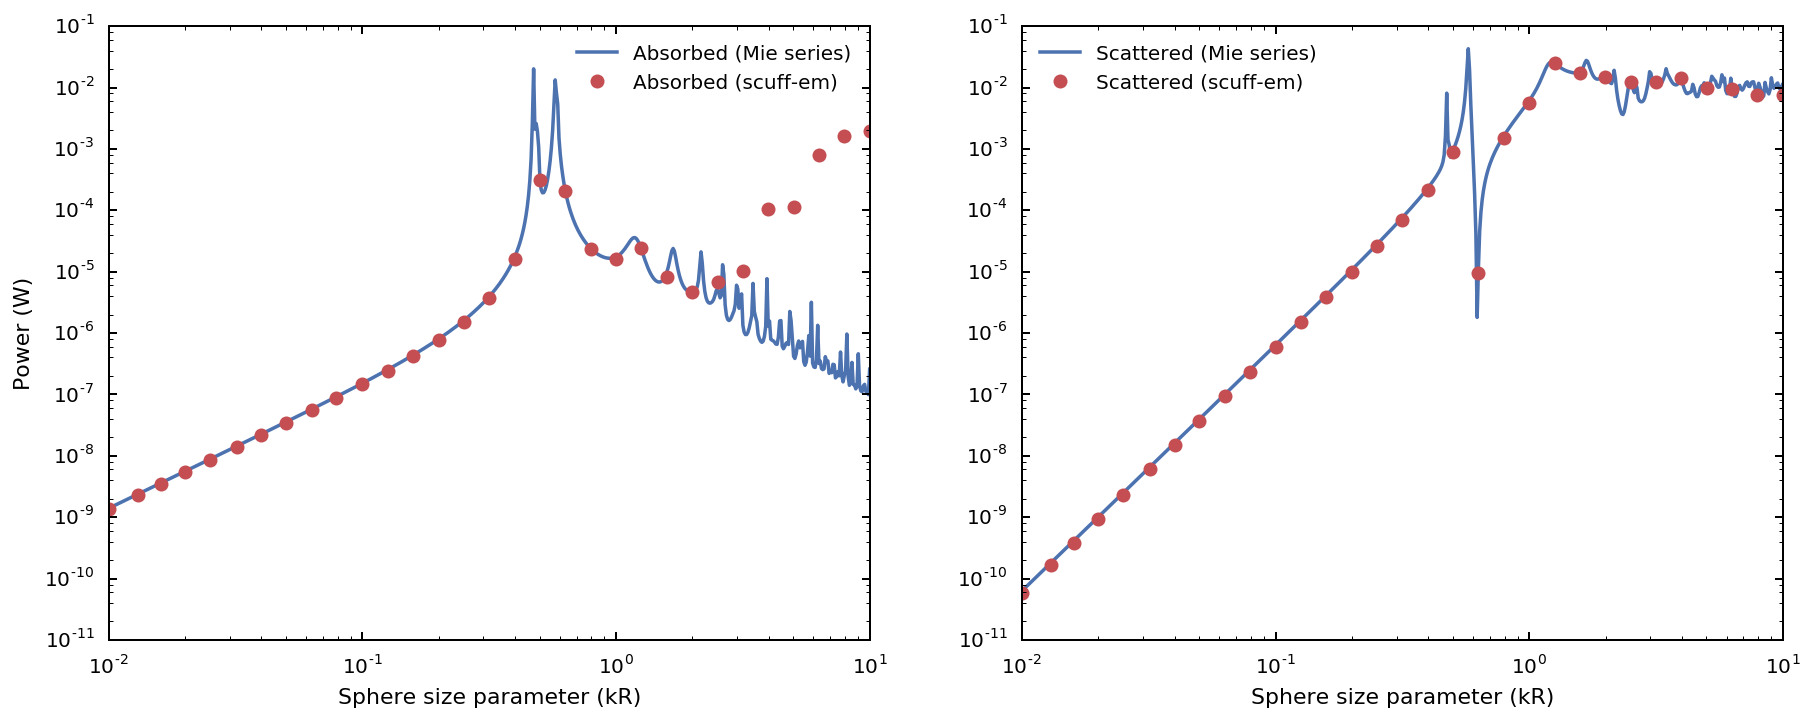

In [17]:
f,(ax1,ax2) = subplots(ncols=2,figsize=(15,5.5))
ax1.plot(  mie_data[0],cS*mie_data[3],'-',label='Absorbed (Mie series)')
ax2.plot(  mie_data[0],cS*mie_data[4],'-',label='Scattered (Mie series)')
ax1.plot(scuff_data[0], scuff_data[1],'o',label='Absorbed (scuff-em)')
ax2.plot(scuff_data[0], scuff_data[2],'o',label='Scattered (scuff-em)')
for ax in ax1,ax2:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-2,1e1)
    ax.set_ylim(1e-11,0.1)
    ax.set_xlabel('Sphere size parameter (kR)')
    ax.legend(loc='upper left',frameon=False,numpoints=1)
ax1.set_ylabel('Power (W)')